In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

from qiskit_aer.noise import (
    NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error
)

## Annex: Simulacions i visualitzacions de circuits amb soroll

Aquest notebook s'ha utilitzat per generar els recursos visuals i experimentals relacionats amb l'execució d'un circuit GHZ sota diferents condicions de soroll. Concretament, s'han realitzat les següents simulacions i execucions:

- **Simulació ideal:** el circuit s'ha executat amb el backend `AerSimulator`, sense cap tipus de soroll, obtenint només els estats esperats \texttt{0000} i \texttt{1111}.
- **Simulació amb soroll artificial:** s'ha definit un model de soroll basat en errors de *bit flip* en les operacions de reset, mesura i portes quàntiques. El circuit transpilat ha estat executat amb aquest model per observar l’impacte dels errors.
- **Execució real en backend d'IBM Quantum:** mitjançant el `Sampler` de Qiskit i seleccionant un backend operatiu amb menys cua, s’ha executat el circuit sobre maquinari quàntic real, obtenint un histograma de sortida amb resultats afectats pel soroll físic inherent als dispositius actuals.

Els histogrames generats han estat desats com a imatges (`.png`) i s’inclouen en aquest treball com a material de suport per a l’anàlisi de la robustesa dels circuits quàntics i la rellevància dels models de soroll en el desenvolupament d’algoritmes quàntics en l’era NISQ.


#### Creació d’un circuit de prova amb entrellaçament
Creem un circuit GHZ amb 4 qubits aplicant una Hadamard i CNOTs en cadena, i el mesurem.


In [34]:
# System Specification
n_qubits = 4
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


#### Executem el circuit GHZ en un simulador ideal i en visualitzem l’histograma de mesures.

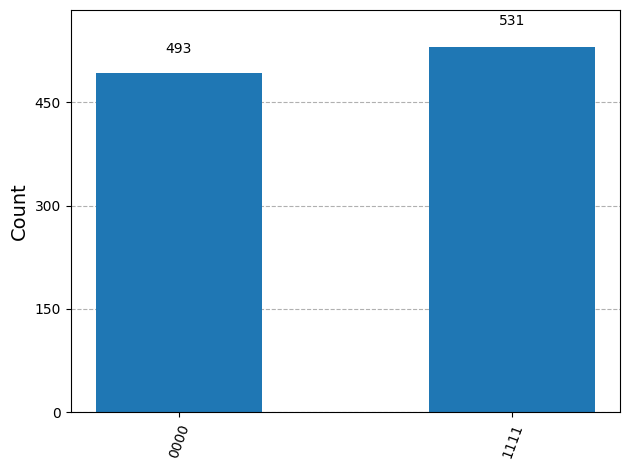

In [35]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result()
hist = plot_histogram(result_ideal.get_counts(0))
# Guardar la figura com a PNG
hist.savefig("sampler_no_noise_histogram.png", dpi=300, bbox_inches='tight')
hist

#### Definim un model de soroll amb errors de bit flip en reset, mesura i portes quàntiques.

In [36]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u3', 'u2', 'reset', 'u1', 'measure']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


#### Executem el circuit en un simulador amb soroll de bit flip i representem l’histograma de sortides.

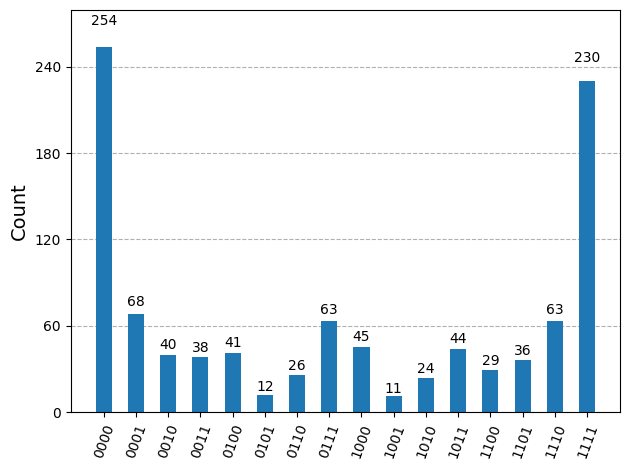

In [31]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
hist = plot_histogram(counts_bit_flip)
hist.savefig("sampler_noise_histogram.png", dpi=300, bbox_inches='tight')
hist

#### Executem el circuit a un backend real d’IBM i visualitzem l’histograma de resultats.

In [ ]:
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
sampler = Sampler(mode=backend, options={"default_shots": 1024})
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend
)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, backend)

# Run and get counts
result_bit_flip = sampler.run([circ_tnoise]).result()

{'0000': 491, '1111': 400, '1000': 37, '0100': 2, '0011': 9, '0111': 38, '0001': 7, '0110': 1, '1011': 8, '1110': 7, '1100': 8, '0010': 3, '1101': 9, '0101': 3, '1001': 1}


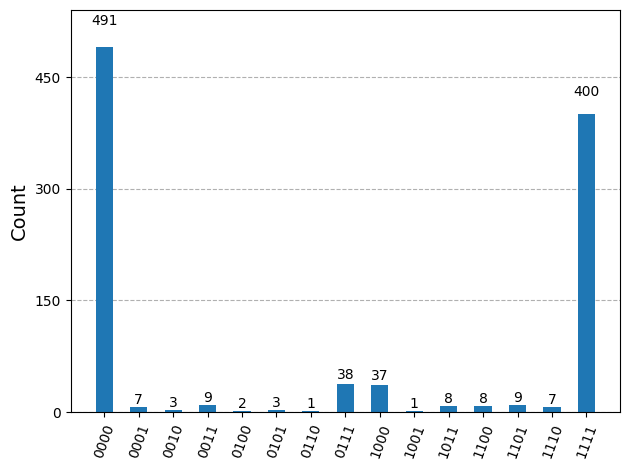

In [28]:
counts = result_bit_flip[0].data.meas.get_counts()
print(counts)
# Plot noisy output
hist = plot_histogram(counts)
hist.savefig("sampler_real_histogram.png", dpi=300, bbox_inches='tight')
hist

In [ ]:
hist.savefig("sampler_real_histogram.png", dpi=300, bbox_inches='tight')